In [177]:
import numpy as np
import cv2
import pandas as pd
import os
import importlib
import time
import matplotlib.pyplot as plt
import ntpath

In [178]:
from utils import msop
#~

In [179]:
SRCDIR = 'images/parrington/'
METAPATH = os.path.join(SRCDIR, 'pano.txt')

def cylindrical_projection(img, focal_length):
    height, width, _ = img.shape
    cylinder_proj = np.zeros(shape=img.shape, dtype=np.uint8)
    
    for y in range(-int(height/2), int(height/2)):
        for x in range(-int(width/2), int(width/2)):
            cylinder_x = focal_length*math.atan(x/focal_length)
            cylinder_y = focal_length*y/math.sqrt(x**2+focal_length**2)
            
            cylinder_x = round(cylinder_x + width/2)
            cylinder_y = round(cylinder_y + height/2)

            if cylinder_x >= 0 and cylinder_x < width and cylinder_y >= 0 and cylinder_y < height:
                cylinder_proj[cylinder_y][cylinder_x] = img[y+int(height/2)][x+int(width/2)]
    
    # Crop black border
    # ref: http://stackoverflow.com/questions/13538748/crop-black-edges-with-opencv
    _, thresh = cv2.threshold(cv2.cvtColor(cylinder_proj, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])
        
    return cylinder_proj[y:y+h, x:x+w]

In [180]:
len(orimgs[0].shape)


3

## Dealing with Meta

In [181]:
with open(METAPATH) as f:
    content = f.readlines()
content = [x.strip() for x in content] 

In [182]:
ii = 0
metas = []
func = None
for line in content:
    if ii == 0:
        if func is None:
            func = ntpath.basename if '\\' in line else os.paht.basename
        meta = {'filename':func(line)}
    elif ii== 11:
        meta['f'] = float(line)
    elif ii == 12:
        ii = 0
        metas.append(meta)
        continue
    ii+=1
    

In [152]:
metas

[{'filename': 'prtn00.jpg', 'f': 704.916},
 {'filename': 'prtn01.jpg', 'f': 706.286},
 {'filename': 'prtn02.jpg', 'f': 705.849},
 {'filename': 'prtn03.jpg', 'f': 706.645},
 {'filename': 'prtn04.jpg', 'f': 706.587},
 {'filename': 'prtn05.jpg', 'f': 705.645},
 {'filename': 'prtn06.jpg', 'f': 705.327},
 {'filename': 'prtn07.jpg', 'f': 704.696},
 {'filename': 'prtn08.jpg', 'f': 703.794},
 {'filename': 'prtn09.jpg', 'f': 704.325},
 {'filename': 'prtn10.jpg', 'f': 704.696},
 {'filename': 'prtn11.jpg', 'f': 703.895},
 {'filename': 'prtn12.jpg', 'f': 704.289},
 {'filename': 'prtn13.jpg', 'f': 704.676},
 {'filename': 'prtn14.jpg', 'f': 704.847},
 {'filename': 'prtn15.jpg', 'f': 704.537},
 {'filename': 'prtn16.jpg', 'f': 705.102},
 {'filename': 'prtn17.jpg', 'f': 705.576}]

In [198]:
n_imgs = 3


## Projection

In [201]:
prjimgs = []
orimgs = []
fs = []
for m in metas[:n_imgs]:
    orimg = cv2.imread(os.path.join(SRCDIR, m['filename']))
    prjimg= msop.cylindrical_projection(orimg, m['f'])
    prjimgs.append(prjimg)
    orimgs.append(orimg)
    fs.append(m['f'])

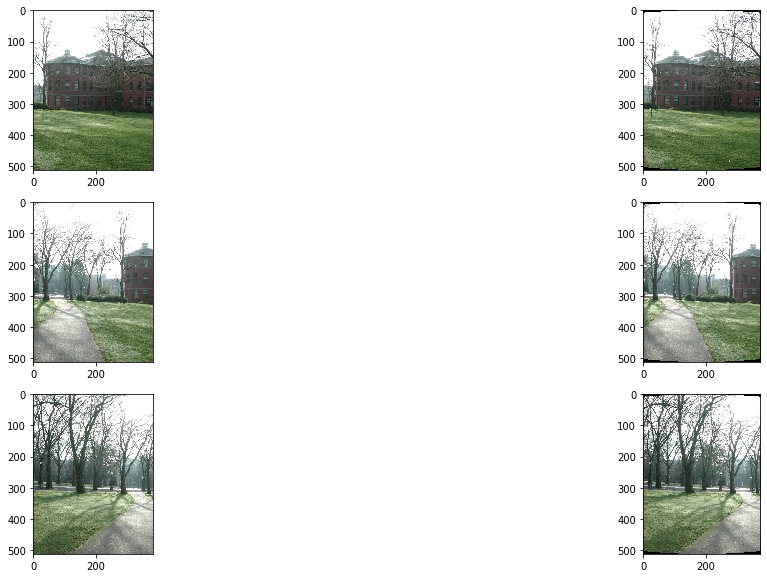

In [202]:
fig=plt.figure(figsize=(20, 10))
columns = 2
rows = len(orimgs)
for i in range(1, rows+1):
    orimg = orimgs[i-1]
    prjimg = prjimgs[i-1]
    fig.subplots_adjust(wspace=0.2)
    fig.add_subplot(rows, columns, i*2-1)
    plt.imshow(cv2.cvtColor(orimg, cv2.COLOR_BGR2RGB)) 
    fig.subplots_adjust(wspace=0.2)
    fig.add_subplot(rows, columns, i*2)
    plt.imshow(cv2.cvtColor(prjimg, cv2.COLOR_BGR2RGB)) 

## Feature Matching

In [238]:
importlib.reload(msop)

<module 'utils.msop' from '/home/tsai/workspace/image-stitching-msop/utils/msop.py'>

In [239]:
descspys = []
for i in range(2):
    descspys.append(msop.msop(orimgs[i], prj=True, focal_length=fs[i])) # put original img into msop function

Computing Harris Corner Response...
Projection to Cylindrical...
Computing Non Maximum Suppression...
Constructing Descriptor...
Computing Harris Corner Response...
Projection to Cylindrical...
Computing Non Maximum Suppression...
Constructing Descriptor...


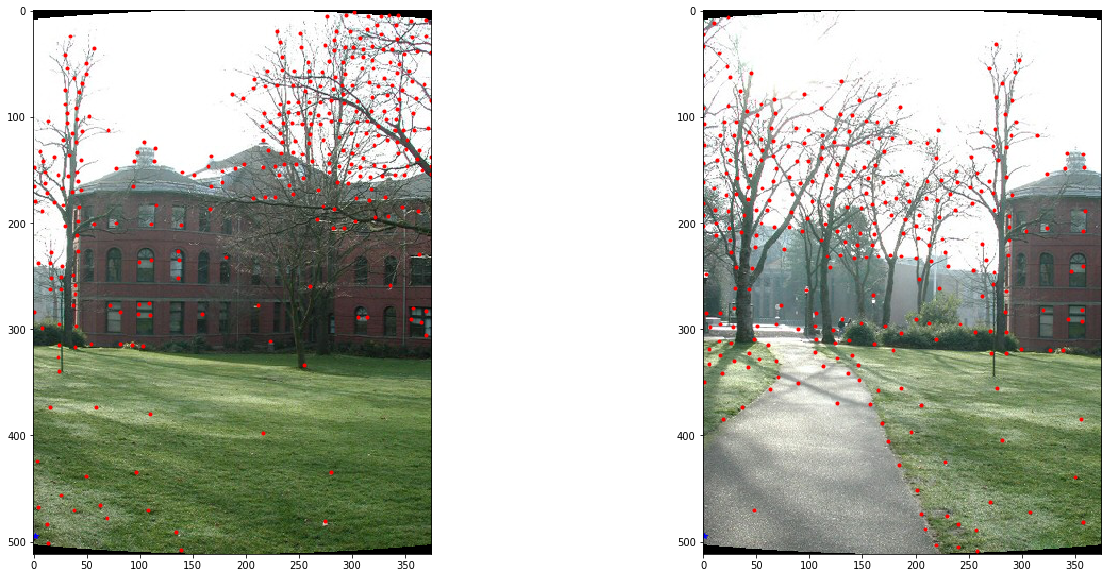

In [240]:
from matplotlib.patches import Rectangle

fig=plt.figure(figsize=(20, 10))
columns = len(descspys)
rows = 1
for i in range(1, columns*rows+1):
    pltimg = prjimgs[i-1]
    
    fig.subplots_adjust(wspace=0.5)
    fig.add_subplot(rows, columns, i)
   
    plt.imshow(cv2.cvtColor(pltimg, cv2.COLOR_BGR2RGB))
    
    #plt.plot( 495, 1, 'g*')
    ax = plt.gca()
    for d in descspys[i-1][0]:
        plt.plot(d.point.y, d.point.x, 'r.')
        #rect = Rectangle( (d.point.y, d.point.x), 30, 30, angle=math.degrees(math.atan2(d.orientation[0], d.orientation[1])), linewidth=1, edgecolor='r', facecolor='none')
        #ax.add_patch(rect)
    plt.plot(1, 495, 'b*')
    
plt.show()

In [208]:
descspys[0][0][2].desc

array([[ 0.90385924,  0.19816224,  1.91199781,  0.96434755,  1.38776575,
         1.08532418, -0.24541873,  0.27881332],
       [ 0.19816224,  0.52076658,  1.89183504,  1.40792852,  1.91199781,
        -0.24541873, -0.14460488,  1.32727744],
       [ 0.90385924,  0.29897609,  1.38776575,  1.32727744,  1.22646358,
        -0.8301391 , -0.34623259,  1.54906792],
       [-1.03176682,  0.21832501,  0.52076658,  1.42809129,  0.62158044,
        -0.30590705, -0.36639536,  1.54906792],
       [-0.78981356, -1.01160405, -0.5478603 ,  0.90385924,  0.60141767,
        -0.85030188,  0.39978995,  0.39978995],
       [-1.15274345, -1.05192959, -0.72932525, -0.95111573, -0.4067209 ,
        -0.95111573,  0.41995272,  0.80304538],
       [-0.85030188, -0.93095296, -1.09225513, -0.91079019, -1.23339453,
        -1.23339453, -0.50753476, -0.4067209 ],
       [-1.1124179 , -1.15274345, -1.13258068, -1.03176682, -1.35437116,
        -1.33420839, -1.21323176, -1.09225513]])

In [125]:
descA[0][2].point.y

141

In [127]:
imgs[0][0, 141]

array([0, 0, 0], dtype=uint8)

In [128]:
imgs[0].shape

(512, 375, 3)

In [219]:
def descspy2arr(descspy):
    darrpy = []
    for descs in descspy:
        numd = len(descs)
        dim = descs[0].desc.flatten().shape[0]
        darr = np.zeros((numd, dim))
        for d in range(numd):
            darr[d, :] = descs[d].desc.flatten().astype('float64')
        darrpy.append(darr)
    return darrpy

In [241]:
darrA = descspy2arr(descspys[0])
darrB = descspy2arr(descspys[1])

In [249]:
X = darrA[0]
Y = darrB[0]

In [243]:
darrA[0].max()

6.890218141039236

In [244]:
X[201]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [245]:
descspys[0][0][201].point.x

495

In [246]:
descspys[0][0][201].point.y

1

In [247]:
np.argwhere(np.isnan(X))

array([], shape=(0, 2), dtype=int64)

In [273]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)


In [274]:
distances, indices = nbrs.kneighbors(Y)

In [275]:
indices

array([[ 77, 239],
       [253, 104],
       [  5, 175],
       [ 36,  89],
       [157, 154],
       [250,  77],
       [163, 125],
       [329, 193],
       [ 78,  26],
       [ 66,  49],
       [201, 257],
       [157, 154],
       [ 93,  25],
       [ 10,  78],
       [ 56, 187],
       [143, 283],
       [138,  72],
       [ 78,  32],
       [ 11,  90],
       [149, 134],
       [ 56, 241],
       [187,  21],
       [318, 146],
       [201, 165],
       [124, 106],
       [ 77, 239],
       [201, 140],
       [ 76, 298],
       [201,  99],
       [ 90,  11],
       [ 47, 227],
       [316, 202],
       [250, 190],
       [167, 243],
       [227, 294],
       [ 78,  10],
       [193, 201],
       [139,  30],
       [104, 253],
       [201, 180],
       [178, 109],
       [253, 104],
       [201, 134],
       [268, 253],
       [209, 206],
       [ 77, 138],
       [201,  18],
       [201, 230],
       [ 90, 160],
       [201, 268],
       [144, 241],
       [201, 189],
       [  1,

In [276]:
distances

array([[5.0778909 , 5.71065798],
       [5.66520928, 6.37529826],
       [6.01083446, 6.23778636],
       [6.1975272 , 6.27893907],
       [5.93812463, 6.40186276],
       [6.82938109, 7.18429217],
       [7.62091973, 7.72259116],
       [2.42527433, 4.24359873],
       [5.8743822 , 6.0879573 ],
       [7.44667819, 7.64653426],
       [8.        , 8.15898199],
       [6.92686596, 7.02967361],
       [3.28795851, 3.74703263],
       [1.90551284, 3.20133242],
       [6.98435753, 7.21463772],
       [5.59326782, 5.8082614 ],
       [7.59378682, 7.74487838],
       [3.52702587, 4.87380095],
       [6.65762519, 7.14520202],
       [5.27961542, 5.56207331],
       [7.05642526, 7.6235943 ],
       [6.65194096, 6.72829397],
       [6.54293667, 7.21266755],
       [8.        , 8.07504403],
       [6.49410858, 7.21988209],
       [3.01275425, 3.80626671],
       [7.99999999, 8.73169422],
       [6.82681615, 6.91097197],
       [8.        , 8.15726405],
       [4.93307295, 5.28412038],
       [2.

In [255]:
np.unravel_index(np.argmax(distances, axis=None),distances.shape)

(284, 0)

In [278]:
B2Apairs = []

for ind in range(len(distances)):
    ds = distances[ind]
    if (ds[0] < ds[1]*0.8):
        B2Apairs.append((ind, indices[ind][0]))
    

In [279]:
len(B2Apairs)

30

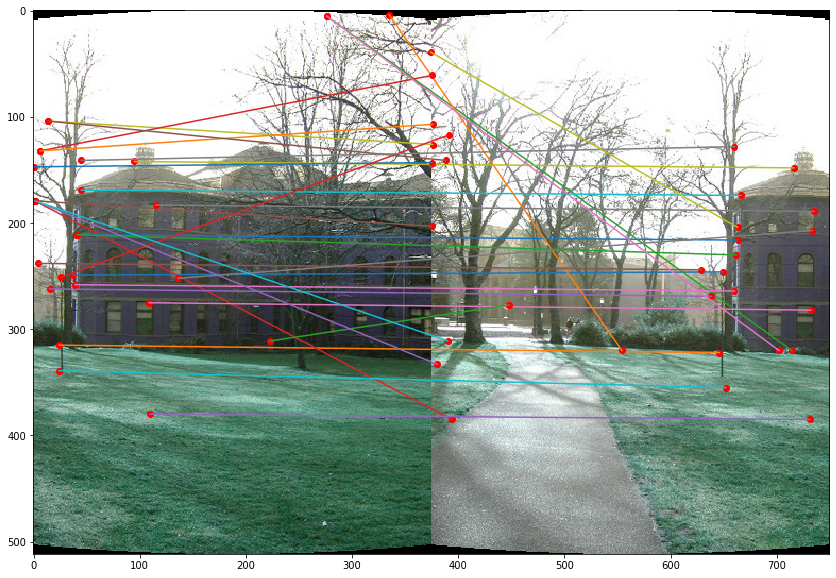

In [303]:
(hA, wA) = prjimgs[0].shape[:2]

(hB, wB) = prjimgs[1].shape[:2]

vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")

vis[0:hA, 0:wA] = prjimgs[0]

vis[0:hB, wA:] = prjimgs[1]
plt.figure(figsize=(20, 10))
plt.imshow(vis)
#隨機選取顏色，繪製所有放置於matches陣列中，兩點的直線。
for (queryIdx, trainIdx) in B2Apairs:

    color = np.random.randint(0, high=255, size=(3,))
    
    plt.plot(descspys[0][0][trainIdx].point.y, descspys[0][0][trainIdx].point.x, 'ro')
    ptA = (int(descspys[0][0][trainIdx].point.x), int(descspys[0][0][trainIdx].point.y))
    plt.plot(descspys[1][0][queryIdx].point.y + wA, descspys[1][0][queryIdx].point.x, 'ro')
    ptB = (int(descspys[1][0][queryIdx].point.x), int(descspys[1][0][queryIdx].point.y + wA))

    #cv2.line(vis, ptA, ptB, (0,0,255), 2)
    #plt.plot([ptA[0], ptB[0]], [ptA[1], ptB[1]])
    plt.plot([ptA[1], ptB[1]], [ptA[0], ptB[0]])
plt.show()

In [290]:
color

array([101, 155,   1])

AttributeError: module 'cv2' has no attribute 'CV_RGB'